In [26]:
#librerias para EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [67]:
#Librerias ML
from sklearn import preprocessing, neighbors
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.metrics import mean_squared_error,roc_auc_score, RocCurveDisplay, recall_score, accuracy_score, confusion_matrix, precision_score

In [10]:
filename='Documents\Fraud.csv'
df=pd.read_csv(filename)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 6362620 entries, 0 to 6362619

Data columns (total 11 columns):

 #   Column          Dtype  

---  ------          -----  

 0   step            int64  

 1   type            object 

 2   amount          float64

 3   nameOrig        object 

 4   oldbalanceOrg   float64

 5   newbalanceOrig  float64

 6   nameDest        object 

 7   oldbalanceDest  float64

 8   newbalanceDest  float64

 9   isFraud         int64  

 10  isFlaggedFraud  int64  

dtypes: float64(5), int64(3), object(3)

memory usage: 534.0+ MB


In [12]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

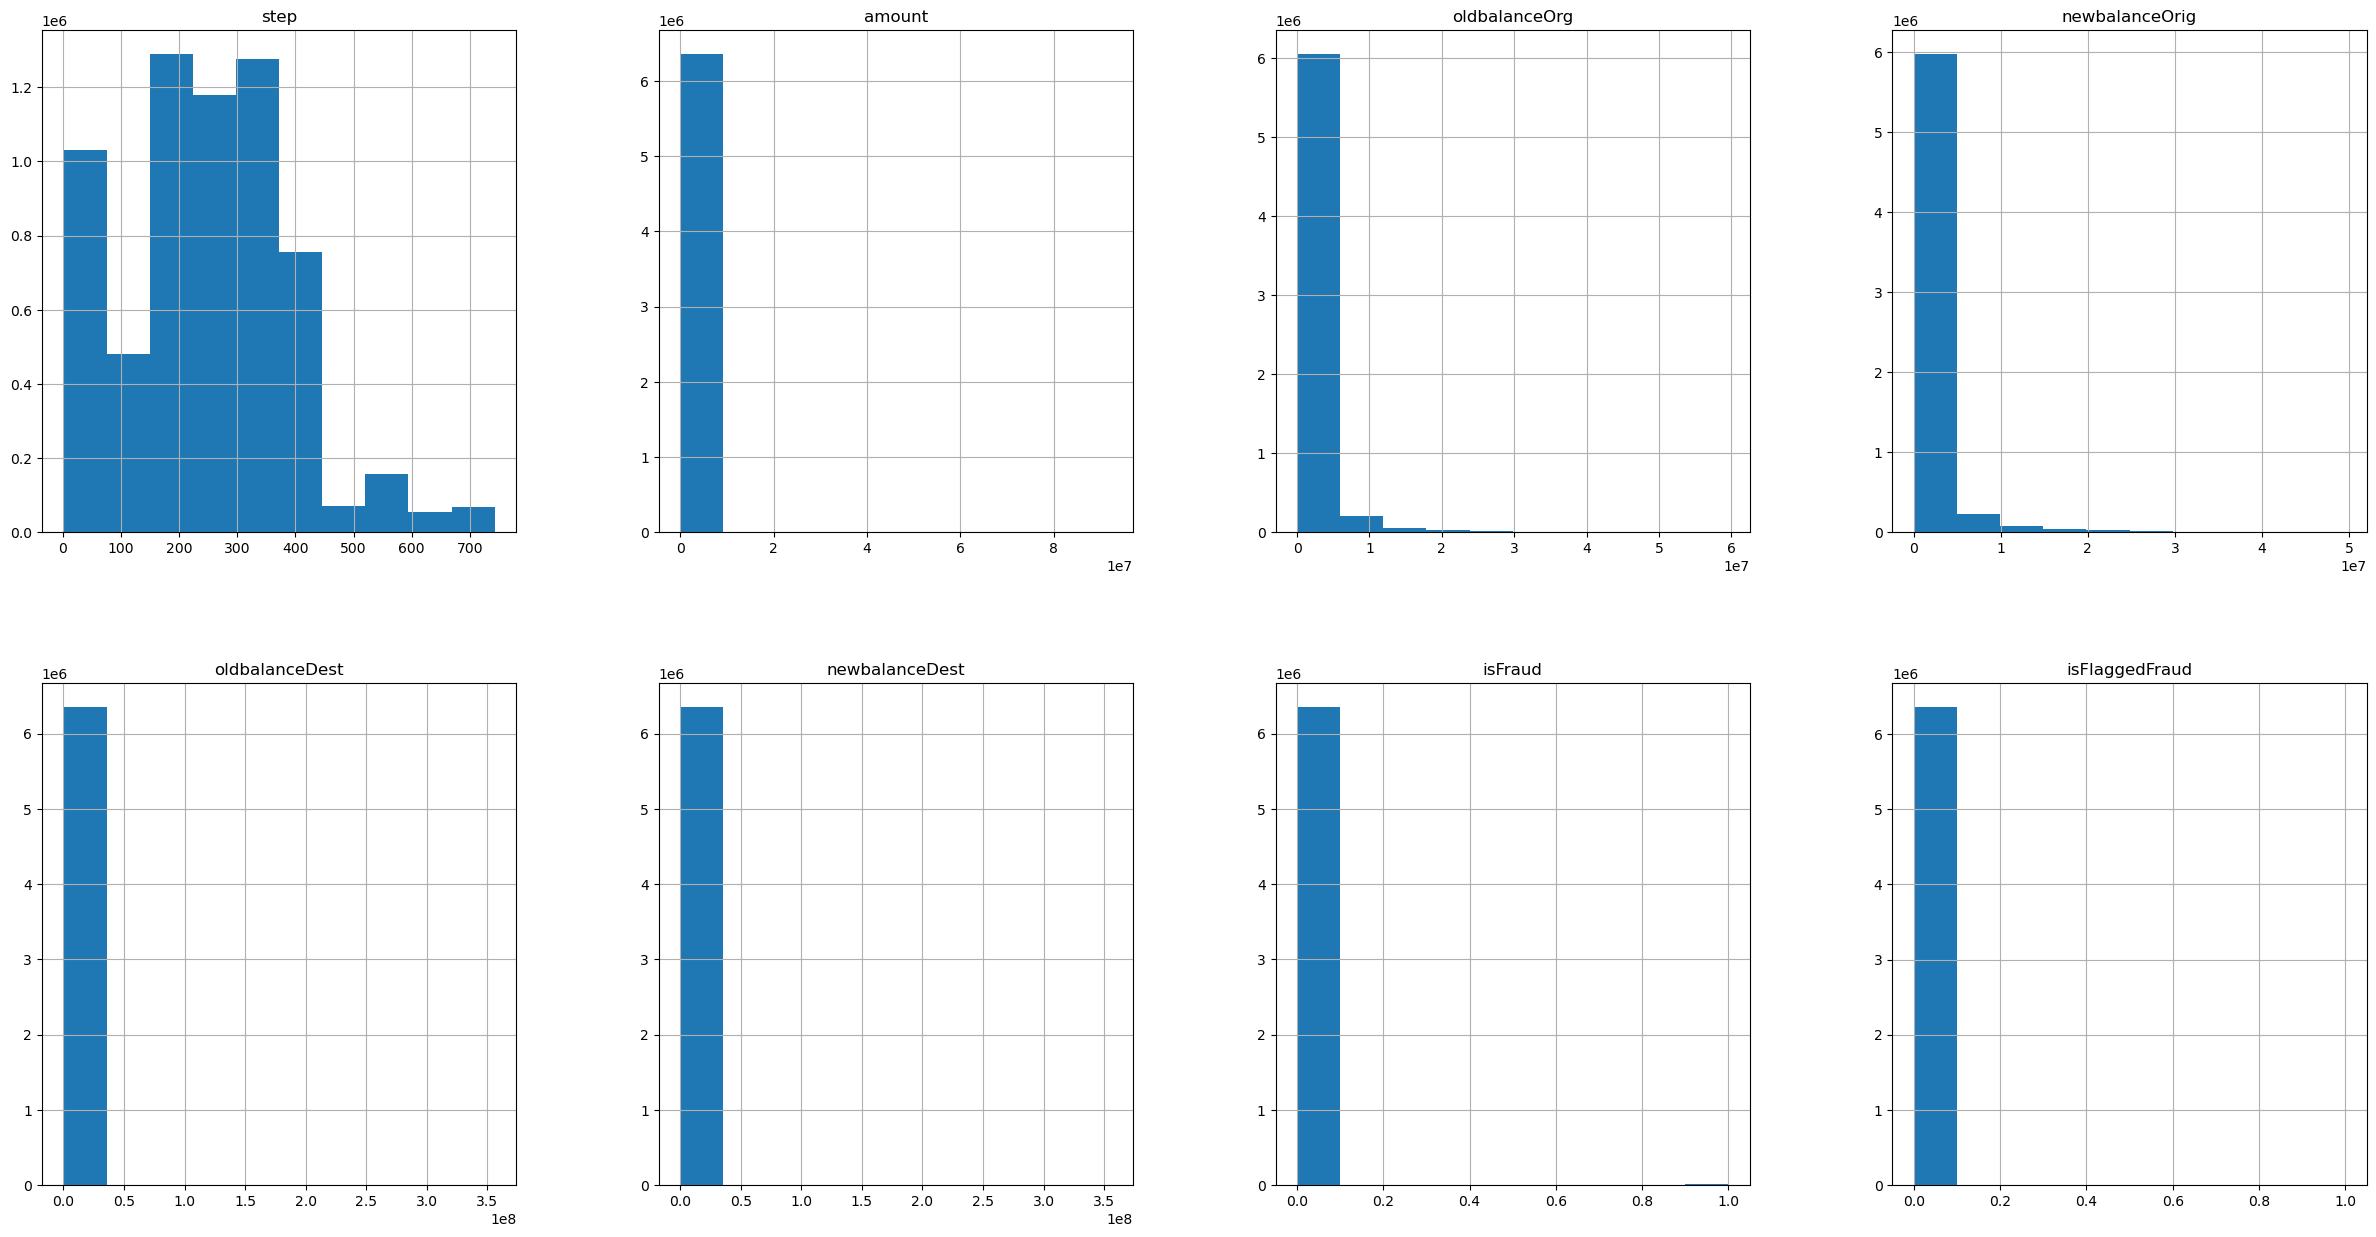

In [16]:
#Analizar variable numéricas
numerical = df.dtypes != object
num_cols = df.loc[:, numerical[numerical == True].keys()]
num_cols.hist(figsize = (30,15), layout = (2,4))
plt.show()

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


<Axes: >

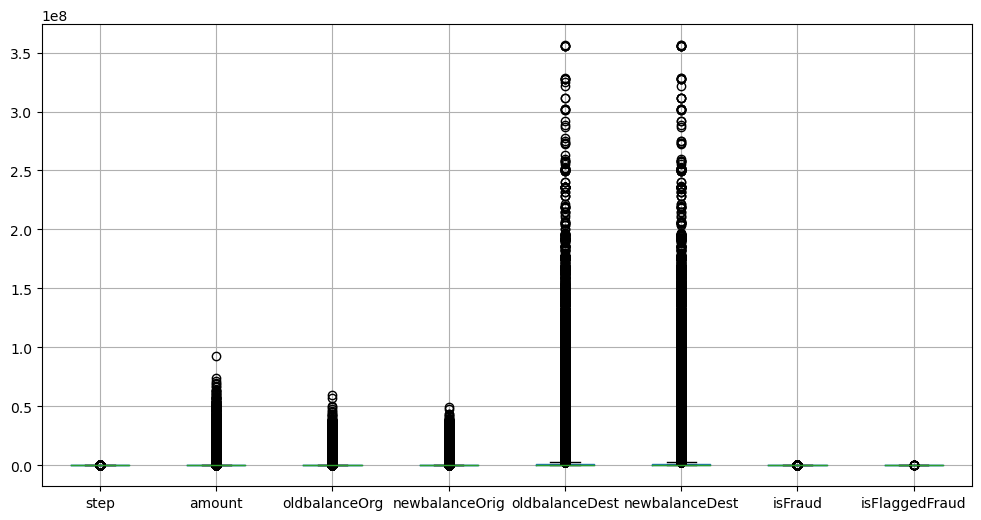

In [18]:
df.boxplot(figsize=(12,6))

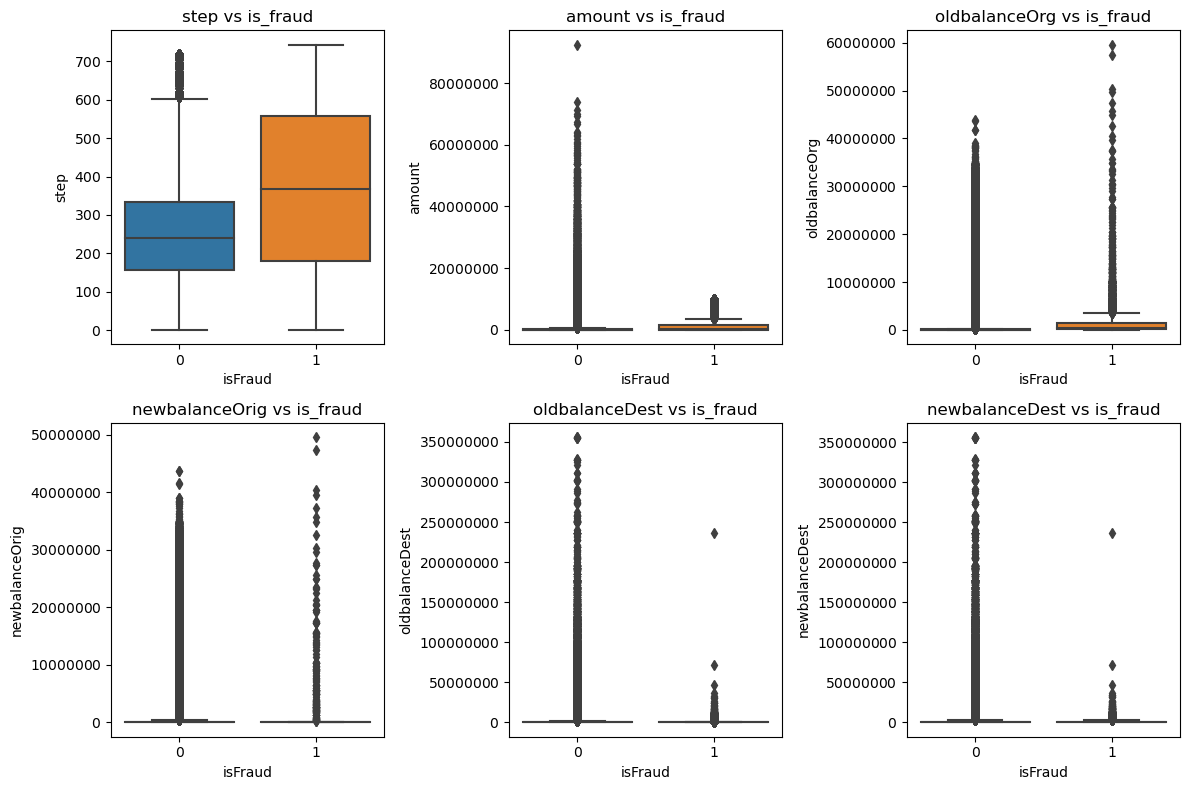

In [28]:
#Distribución de los datos según la variable isFraud
numeric_columns = df.select_dtypes(include=['number']).drop(columns=['isFraud','isFlaggedFraud'])

plt.figure(figsize=(12, 8))

for i, column in enumerate(numeric_columns):
    plt.subplot(2, 3, i + 1)  # Subplots en una cuadrícula
    ax = sns.boxplot(x='isFraud', y=column, data=df)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
    plt.title(f'{column} vs is_fraud')

plt.tight_layout()
plt.show()

C:\Users\mrodriguezs\AppData\Local\Temp\ipykernel_27448\1852086644.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

  corrmat = df.corr()


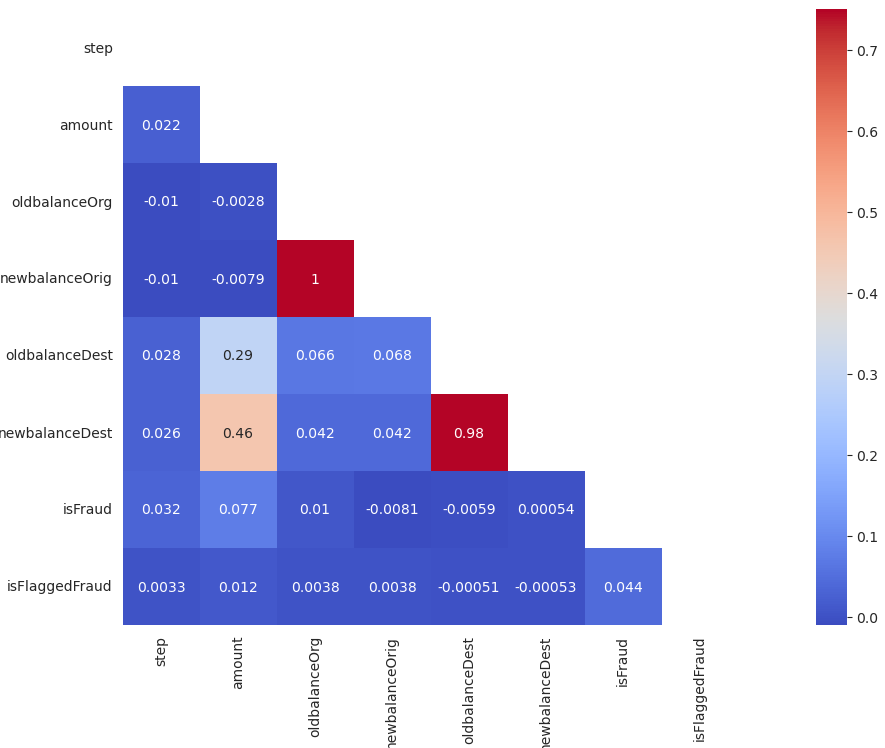

In [29]:
corrmat = df.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
   f, ax = plt.subplots(figsize=(20, 8))
   ax = sns.heatmap(corrmat, mask=mask, vmax=.75, square=True, annot=True, cmap="coolwarm")

Existe alta correlación entre las 2 variables OldBalance y Newbalance, estp podría indicar multicolinealidad entre estas variables y afectar los resultados del modelo. Por lo que se considerará trabajar unicamente con las variables NewBalance

In [30]:
df.drop(columns=['oldbalanceDest', 'oldbalanceOrg'], inplace=True)

C:\Users\mrodriguezs\AppData\Local\Temp\ipykernel_27448\3347196683.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

  corrmat = df.corr()


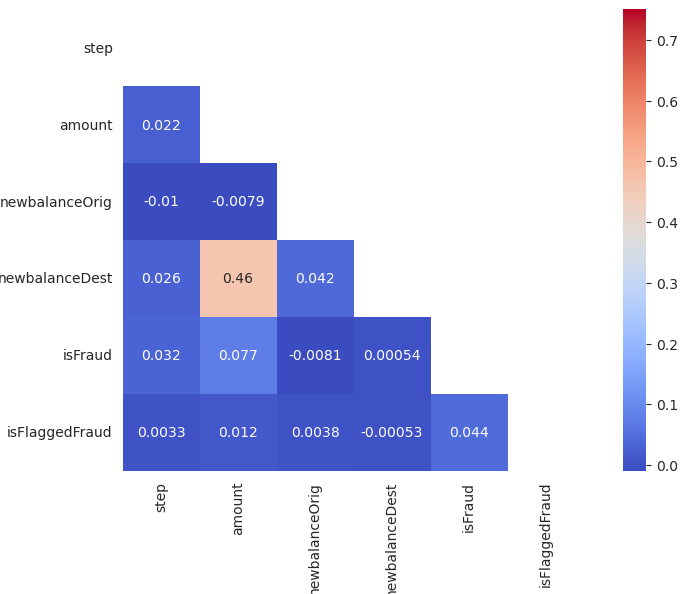

In [36]:
corrmat = df.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
   f, ax = plt.subplots(figsize=(10, 6))
   ax = sns.heatmap(corrmat, mask=mask, vmax=.75, square=True, annot=True, cmap="coolwarm")

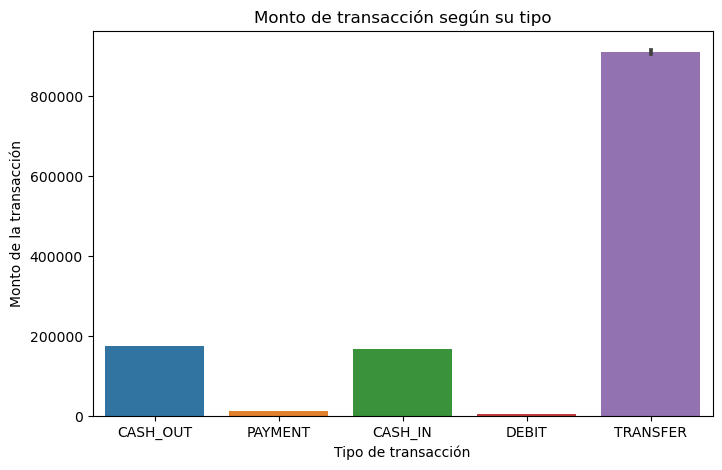

In [39]:
# the highest transaction amount is transfered by TRANSFER type
plt.figure(figsize=(8, 5))
sns.barplot(data=df.sort_values(by='amount'), x='type', y='amount')
plt.xticks(rotation=0)  
plt.xlabel('Tipo de transacción')
plt.ylabel('Monto de la transacción')
plt.title('Monto de transacción según su tipo')
plt.show()

In [40]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

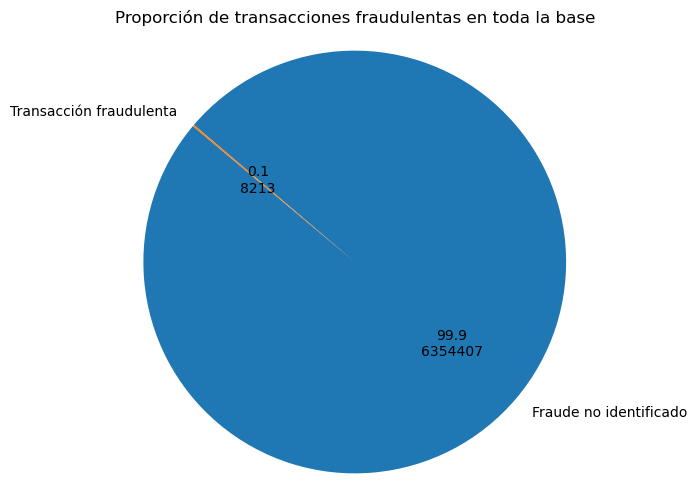

In [47]:
fraud_counts=df.isFraud.value_counts()
fraud_labels=['Fraude no identificado', 'Transacción fraudulenta']
fraud_values=[fraud_counts[0], fraud_counts[1]]

def func(pct,allvals):
    absolute=int(round(pct/100.*sum(allvals)))
    return f'{pct:.1f}\n{absolute:d}'

plt.figure(figsize=(6,6))
plt.pie(fraud_values, labels=fraud_labels,autopct=lambda pct:func(pct,fraud_values), startangle=140)
plt.title('Proporción de transacciones fraudulentas en toda la base')
plt.axis('equal')
plt.show()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 6362620 entries, 0 to 6362619

Data columns (total 9 columns):

 #   Column          Dtype  

---  ------          -----  

 0   step            int64  

 1   type            object 

 2   amount          float64

 3   nameOrig        object 

 4   newbalanceOrig  float64

 5   nameDest        object 

 6   newbalanceDest  float64

 7   isFraud         int64  

 8   isFlaggedFraud  int64  

dtypes: float64(3), int64(3), object(3)

memory usage: 436.9+ MB


In [53]:
train=df.drop(columns=['nameOrig','nameDest','isFlaggedFraud'])
train.head()

,step,type,amount,newbalanceOrig,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,160296.36,0.0,0
1,1,PAYMENT,1864.28,19384.72,0.0,0
2,1,TRANSFER,181.00,0.00,0.0,1
3,1,CASH_OUT,181.00,0.00,0.0,1
4,1,PAYMENT,11668.14,29885.86,0.0,0


In [54]:
train=pd.get_dummies(train, columns=['type'], prefix=['type'])
train.head()

,step,amount,newbalanceOrig,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,160296.36,0.0,0,0,0,0,1,0
1,1,1864.28,19384.72,0.0,0,0,0,0,1,0
2,1,181.00,0.00,0.0,1,0,0,0,0,1
3,1,181.00,0.00,0.0,1,0,1,0,0,0
4,1,11668.14,29885.86,0.0,0,0,0,0,1,0


In [91]:
X=train.drop(columns='isFraud')
y=df['isFraud']

In [92]:
#Balancear la data para el entrenamiento de los modelos
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)

In [93]:
y.value_counts()

0    6354407
1    6354407
Name: isFraud, dtype: int64

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=10)

In [95]:
# Escalar
scaler = StandardScaler()
# Ajustar solo al conjunto de entrenamiento
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [96]:
models=[
    (RandomForestClassifier(),{'n_estimators':[50, 100, 200, 300],'max_depth':[None, 50,10,15]}),
    (LogisticRegression(),{'C':[0.1,1,10,20], 'solver':['liblinear', 'lbfgs']}),
    (SVC(),{'C':[0.1,1,10,20], 'kernel':['linear', 'rbf']}),
    (XGBClassifier())
]

In [97]:
"""
model_list=['Random Forest','Regresión Logistica', 'Support Vector Machine', 'XG Boost']
accuracy_list=[]

for model, params in models:
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_params=grid_search.best_params_
    best_scrore=grid_searcj.best_score_
    predictions=best_model.predict(X_test)
    
    accuracy=accuracy_score(y_test, predictions)
    print(f"Precisión para {model._class.name_}: {accuracy}")
    
    conf_matrix=confusion_matrix(y_test, predictions)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True,cmap='Blues', fmt='d',
               xticklabels=data.target_names, yticklabels=data.target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de confusion para {model.__class__.__name__}')
    plt.show()
    
"""

'\nmodel_list=[\'Random Forest\',\'Regresión Logistica\', \'Support Vector Machine\', \'XG Boost\']\naccuracy_list=[]\n\nfor model, params in models:\n    grid_search = GridSearchCV(model, params, cv=5, scoring=\'accuracy\')\n    grid_search.fit(X_train, y_train)\n    \n    best_params=grid_search.best_params_\n    best_scrore=grid_searcj.best_score_\n    predictions=best_model.predict(X_test)\n    \n    accuracy=accuracy_score(y_test, predictions)\n    print(f"Precisión para {model._class.name_}: {accuracy}")\n    \n    conf_matrix=confusion_matrix(y_test, predictions)\n    \n    plt.figure(figsize=(8,6))\n    sns.heatmap(conf_matrix, annot=True,cmap=\'Blues\', fmt=\'d\',\n               xticklabels=data.target_names, yticklabels=data.target_names)\n    plt.xlabel(\'Predicted\')\n    plt.ylabel(\'Actual\')\n    plt.title(f\'Matriz de confusion para {model.__class__.__name__}\')\n    plt.show()\n    \n'

In [98]:
'''# Define los hiperparámetros para RandomForestClassifier
param_grid = {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 50, 10, 15]}

# Configura GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtiene el mejor modelo con los mejores parámetros
best_model = grid_search.best_estimator_

# Realiza predicciones con el mejor modelo utilizando el conjunto de prueba
predictions = best_model.predict(X_test)

# Evalúa las predicciones
accuracy = accuracy_score(y_test, predictions)
print(f"Precisión del modelo: {accuracy}")

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, predictions)

# Imprime la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()
'''

'# Define los hiperparámetros para RandomForestClassifier\nparam_grid = {\'n_estimators\': [50, 100, 200, 300], \'max_depth\': [None, 50, 10, 15]}\n\n# Configura GridSearchCV para encontrar los mejores parámetros\ngrid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring=\'accuracy\')\ngrid_search.fit(X_train, y_train)\n\n# Obtiene el mejor modelo con los mejores parámetros\nbest_model = grid_search.best_estimator_\n\n# Realiza predicciones con el mejor modelo utilizando el conjunto de prueba\npredictions = best_model.predict(X_test)\n\n# Evalúa las predicciones\naccuracy = accuracy_score(y_test, predictions)\nprint(f"Precisión del modelo: {accuracy}")\n\n# Calcula la matriz de confusión\nconf_matrix = confusion_matrix(y_test, predictions)\n\n# Imprime la matriz de confusión\nplt.figure(figsize=(8, 6))\nsns.heatmap(conf_matrix, annot=True, cmap=\'Blues\', fmt=\'d\', \n            xticklabels=data.target_names, yticklabels=data.target_names)\nplt.xlabel(\'Predicted\

In [99]:
clf=RandomForestClassifier(n_estimators=100, max_depth=20, oob_score=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, oob_score=True)

In [100]:
predictions=clf.predict(X_test)


In [101]:
clf.score(X_test, y_test)

0.9534421580611567

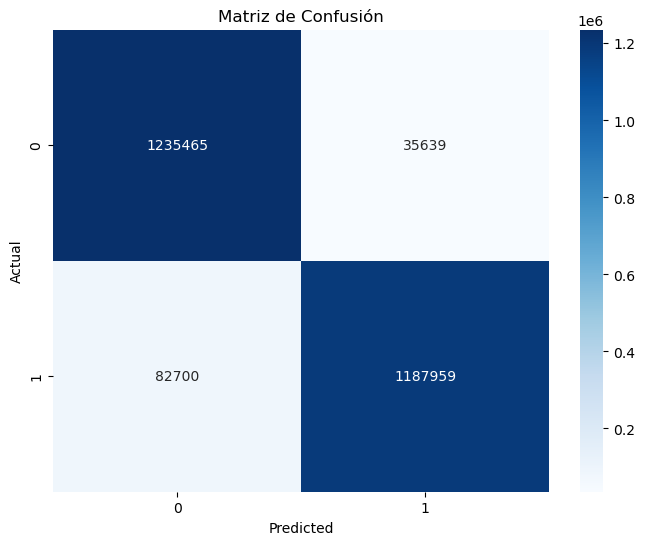

In [102]:
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Ajustar el modelo de Bosques Aleatorios
clf.fit(X_train, y_train)

# Obtener las predicciones en el conjunto de test
predictions = clf.predict(X_test)

# Aplicar t-SNE para reducir la dimensionalidad a 2 componentes
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_test)

# Crear una visualización de dispersión
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=predictions, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=['No Fraude', 'Fraude'])
plt.title('Visualización de Grupos utilizando t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

In [ ]:
feature_importance = clf.feature_importances_
feature_names = X.columns

# Crear un DataFrame con las características y sus importancias
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Graficar las características importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df[:15], palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 15 Feature Importances')
plt.show()